In [1]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


## Imports

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import re
import statistics as stats  
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


2024-09-14 03:14:09.119328: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 03:14:09.135988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 03:14:09.156900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 03:14:09.163104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 03:14:09.177869: I tensorflow/core/platform/cpu_feature_guar

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Functions/Classes

In [6]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.math.reduce_mean(tf.math.reduce_sum(loss, axis=-1))
    return focal_loss_fixed

In [7]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, train_data):
        super().__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []

    def on_epoch_end(self, epoch, logs=None):
        val_X, val_y = self.validation_data
        y_pred_val = (self.model.predict(val_X) > 0.5).astype("int32")
        
        train_X, train_y = self.train_data
        y_pred_train = (self.model.predict(train_X) > 0.5).astype("int32")

        val_f1 = f1_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_precision = precision_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_recall = recall_score(val_y, y_pred_val, average='weighted', zero_division=0)

        train_f1 = f1_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_precision = precision_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_recall = recall_score(train_y, y_pred_train, average='weighted', zero_division=0)

        self.train_accuracy.append(logs['accuracy'])
        self.val_accuracy.append(logs['val_accuracy'])
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)

        # Exibir as métricas no final de cada época
        print(f"\nEpoch {epoch + 1} - Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")


In [8]:


class MetricsCallback_2(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, train_data):
        super().__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []

    def on_epoch_end(self, epoch, logs=None):
        # Get validation data
        val_X, val_y = self.validation_data
        train_X, train_y = self.train_data

        # Predict validation and training data
        y_pred_val = np.argmax(self.model.predict(val_X), axis=1)  # Convert to class labels
        y_pred_train = np.argmax(self.model.predict(train_X), axis=1)  # Convert to class labels

        # Calculate validation metrics
        val_f1 = f1_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_precision = precision_score(val_y, y_pred_val, average='weighted', zero_division=0)
        val_recall = recall_score(val_y, y_pred_val, average='weighted', zero_division=0)
        
        # Calculate training metrics
        train_f1 = f1_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_precision = precision_score(train_y, y_pred_train, average='weighted', zero_division=0)
        train_recall = recall_score(train_y, y_pred_train, average='weighted', zero_division=0)

        # Store metrics
        self.train_accuracy.append(logs['accuracy'])
        self.val_accuracy.append(logs['val_accuracy'])
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)

        # Print metrics for each epoch
        print(f"\nEpoch {epoch + 1} - Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")


In [9]:
def plot_metrics(metrics_callback):
    epochs = range(1, len(metrics_callback.train_accuracy) + 1)

    # Plotando a acurácia
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics_callback.train_accuracy, label='Train Accuracy')
    plt.plot(epochs, metrics_callback.val_accuracy, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotando o F1-Score
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics_callback.train_f1, label='Train F1-Score')
    plt.plot(epochs, metrics_callback.val_f1, label='Val F1-Score')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # Plotando a precisão
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics_callback.train_precision, label='Train Precision')
    plt.plot(epochs, metrics_callback.val_precision, label='Val Precision')
    plt.title('Precision per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plotando o recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics_callback.train_recall, label='Train Recall')
    plt.plot(epochs, metrics_callback.val_recall, label='Val Recall')
    plt.title('Recall per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [10]:
def Conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
def Conf_matrix_2(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

## Data Loading

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [13]:
# Load the data to inspect it
file_path =  "/teamspace/studios/this_studio/archive (3)/labeled_data.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Data Analysis

In [14]:
print(data.head())
print(data.describe())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
         Unnamed: 0         count   hate_speech  offensive_language  \
count  24783.000000  24783.000000  24783.000000        24783.000000   
mean   12681.192027      3.243473      0.280515            2.413711   
std     7299.55386

In [15]:
class_counts = data['class'].value_counts()


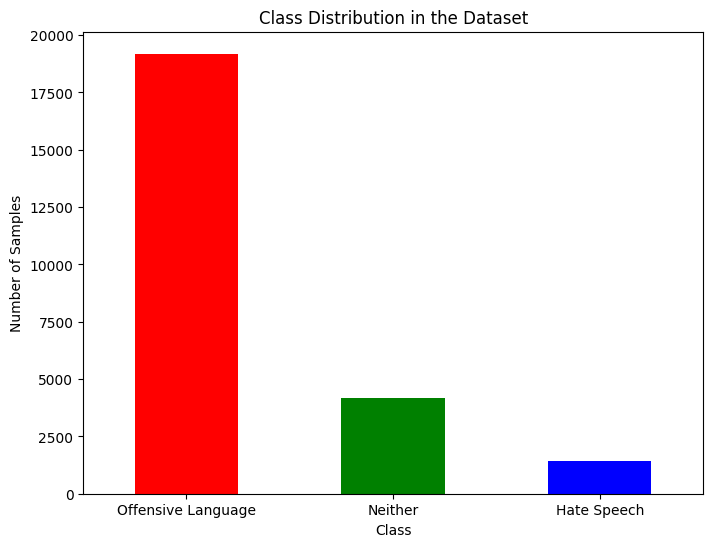

In [16]:
class_labels = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}

plt.figure(figsize=(8, 6))
class_counts.rename(index=class_labels).plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

## Data Preprocessing

In [17]:
# Remove the unnecessary 'Unnamed: 0' column
data_cleaned = data.drop(columns=['Unnamed: 0'])

In [18]:
missing_values = data_cleaned.isnull().sum()


In [19]:
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove menções
    text = re.sub(r'@\w+', '', text)
    
    # Remove caracteres especiais e números, mantendo apenas letras e espaços
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Converte para minúsculas
    text = text.lower()
    
    # Divide o texto em palavras e remove as stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Junta as palavras de volta em uma string
    clean_text = ' '.join(words)
    
    return clean_text

In [20]:
data_cleaned['tweet'] = data_cleaned['tweet'].apply(clean_tweet)


In [21]:
data_cleaned.head(), missing_values


(   count  hate_speech  offensive_language  neither  class  \
 0      3            0                   0        3      2   
 1      3            0                   3        0      1   
 2      3            0                   3        0      1   
 3      3            0                   2        1      1   
 4      6            0                   6        0      1   
 
                                                tweet  
 0  rt woman shouldnt complain cleaning house amp ...  
 1  rt boy dats coldtyga dwn bad cuffin dat hoe st...  
 2  rt dawg rt ever fuck bitch start cry confused ...  
 3                                rt look like tranny  
 4  rt shit hear might true might faker bitch told ya  ,
 count                 0
 hate_speech           0
 offensive_language    0
 neither               0
 class                 0
 tweet                 0
 dtype: int64)

In [22]:
data_cleaned.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


# LSTM

## Splitting the Dataset and Tokenization

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned["tweet"], data_cleaned['class'], test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [24]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [25]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length


print(max_length)

25


In [26]:
X_train = pad_sequences(X_train,maxlen=max_length,padding='post')
X_test = pad_sequences(X_test,maxlen=max_length,padding='post')

In [27]:
vocab_size = len(word_index) + 1
embedding_dim = 128
max_length = 25  # Tamanho máximo das sequências, definido previamente
l2_reg = 0.01  # Regularization term


In [28]:
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

In [29]:
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


## Modeling

In [30]:
model = Sequential([
    # Embedding layer
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    
    # Convolutional layer
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),
    
    # Batch Normalization
    BatchNormalization(),
    
    # Max Pooling layer
    MaxPooling1D(pool_size=2),
    
    # LSTM layer with L2 regularization and dropout
    LSTM(32, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)),
    
    # Dropout layer to prevent overfitting
    Dropout(0.5),
    
    # Dense layer with reduced units and L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    
    # Dropout
    Dropout(0.5),
    
    # Output layer with softmax activation
    Dense(3, activation='softmax'),
])

# Compile the model
model.compile(loss=focal_loss(gamma=2., alpha=0.25), optimizer='adam', metrics=['accuracy'])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1726283652.404553  138238 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726283652.407058  138238 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726283652.407241  138238 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at htt

## Training/Results

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [32]:
print("Classes únicas no conjunto de treino:", np.unique(y_train))


Classes únicas no conjunto de treino: [0. 1.]


In [33]:
print(f"Tipo de y_train: {y_train.dtype}")
y_train = y_train.astype('int')


Tipo de y_train: float64


In [34]:
class_weights_dict = {
    0: 2.0,  # Higher weight for class 0 (minority)
    1: 1.0,  # Default weight for class 1 (dominant class)
    2: 1.5   # Somewhat higher weight for class 2 (moderate class)
}

In [35]:
metrics_callback = MetricsCallback(validation_data=(X_test_padded, y_test), train_data=(X_train_padded, y_train))


In [36]:
# Treinamento do modelo
history = model.fit(
    X_train_padded,           # Dados de treino após padding
    y_train,                 # Rótulos de treino
    epochs=15,               # Número de épocas
    batch_size=32,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    validation_data=(X_test_padded, y_test),  # Dados de validação
    callbacks=[early_stopping, metrics_callback],
    verbose=2,                # Nível de detalhamento do output
    class_weight=class_weights_dict  # Pass the class weights here
)

# Avaliar o modelo nos dados de teste
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'Acurácia no conjunto de teste: {test_accuracy}')


Epoch 1/15


2024-09-14 03:14:16.979211: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
W0000 00:00:1726283657.062740  138530 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726283657.159481  138530 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726283657.160235  138530 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726283657.162504  138530 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726283657.169431  138530 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726283657.170121  138530 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726283657.170848  138530 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726283657.171553  138530 gpu_t

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Epoch 1 - Train F1: 0.8442, Train Precision: 0.8850, Train Recall: 0.8212
Val F1: 0.8051, Val Precision: 0.8660, Val Recall: 0.7835
620/620 - 21s - 34ms/step - accuracy: 0.8260 - loss: 0.2337 - val_accuracy: 0.8874 - val_loss: 0.0464
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Epoch 2 - Train F1: 0.8881, Train Precision: 0.8775, Train Recall: 0.8990
Val F1: 0.8596, Val Precision: 0.8576, Val Recall: 0.8624
620/620 - 13s - 20ms/step - accuracy: 0.8952 - loss: 0.0488 - val_accuracy: 0.8937 - val_loss: 0.0425
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
620/620 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Epoch 3 - Train F1: 0.8983, Train Precision: 0.8828, Train Recall: 0.9145
Val F1: 0.8601, Val Precision: 0.8575, Val Recall: 0.8632
620/620 - 13s - 20ms/step - accuracy: 0.9117 - loss: 0.0419 - val_accuracy: 0.8917 - val_loss: 0.0406
Epoch 4/15
155/155 ━━━━━━━━

In [37]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'Acurácia no conjunto de teste: {test_accuracy}')

155/155 - 1s - 4ms/step - accuracy: 0.8917 - loss: 0.0406
Acurácia no conjunto de teste: 0.8916683197021484


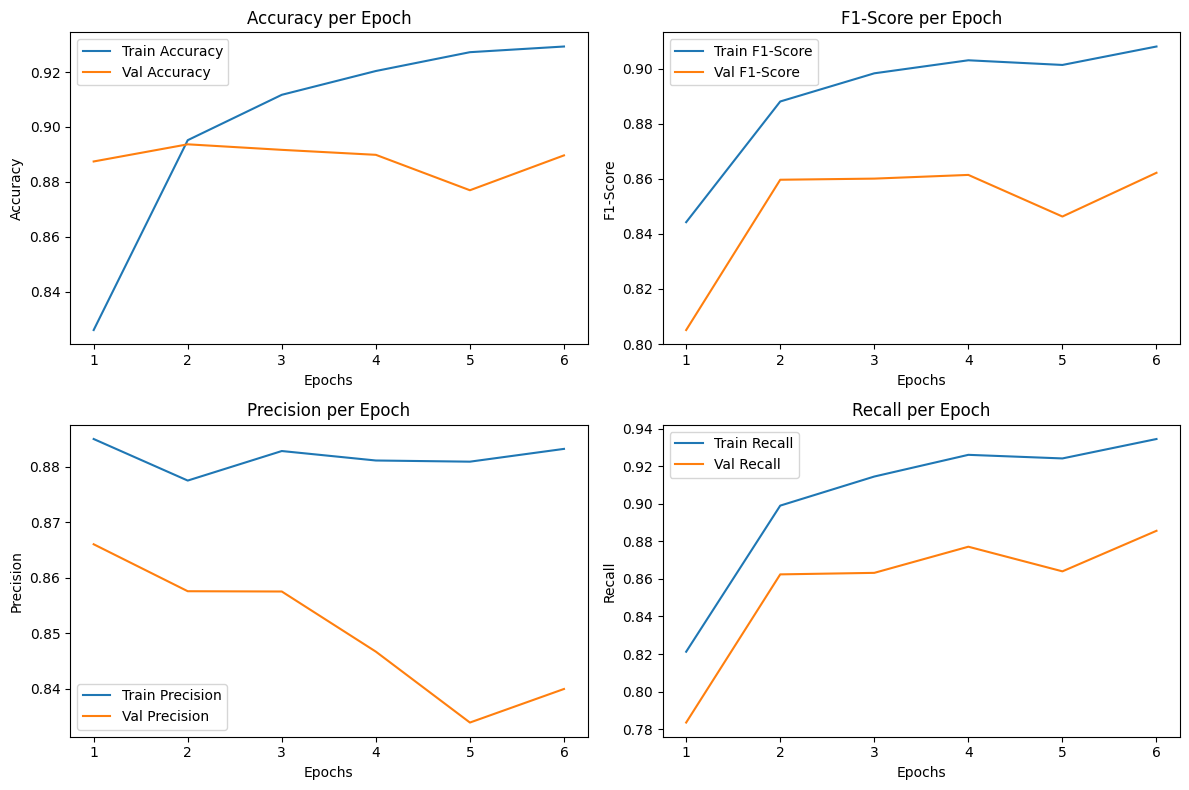

In [38]:
plot_metrics(metrics_callback)


In [39]:
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

In [40]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


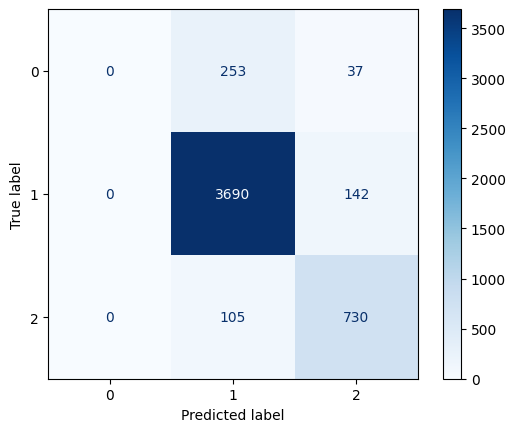

In [41]:
Conf_matrix_2(y_test, y_pred_classes)


# Baseline Neural Network

## Vectorization

In [42]:
data_cleaned['tokens'] = data_cleaned['tweet'].apply(word_tokenize)


In [43]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, min_df=2)
tfidf_matrix = vectorizer.fit_transform(data_cleaned['tokens'])

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [44]:
smote = SMOTE()

# Aplicar o SMOTE ao conjunto de dados
X_smote, y_smote = smote.fit_resample(tfidf_matrix, data_cleaned['class'])

# Verificar a nova distribuição das classes
print("Distribuição das classes após o SMOTE:", np.bincount(y_smote))

Distribuição das classes após o SMOTE: [19190 19190 19190]


## Model

In [45]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_smote.shape[1]),  # First Dense Layer
    Dropout(0.5),                                               # Dropout layer after first dense layer
    Dense(64, activation='relu'),                               # Second Dense Layer
    Dropout(0.5),                                               # Dropout layer after second dense layer
    Dense(3, activation='softmax')                              # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

metrics_callback = MetricsCallback_2(validation_data=(X_test, y_test), train_data=(X_train, y_train))

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), callbacks=[metrics_callback])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1726283743.317988  138528 service.cc:146] XLA service 0x7f8f8c06dd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726283743.318014  138528 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-09-14 03:15:43.343372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/360 ━━━━━━━━━━━━━━━━━━━━ 15:06 3s/step - accuracy: 0.4219 - loss: 1.0974

I0000 00:00:1726283745.006892  138528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Epoch 1 - Train F1: 0.9368, Train Precision: 0.9371, Train Recall: 0.9371
Val F1: 0.9211, Val Precision: 0.9216, Val Recall: 0.9215
360/360 ━━━━━━━━━━━━━━━━━━━━ 266s 733ms/step - accuracy: 0.6925 - loss: 0.7416 - val_accuracy: 0.9215 - val_loss: 0.2289
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   - accuracy:
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 2 - Train F1: 0.9684, Train Precision: 0.9686, Train Recall: 0.9685
Val F1: 0.9441, Val Precision: 0.9451, Val Recall: 0.9444
360/360 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.9324 - loss: 0.2149 - val_accuracy: 0.9444 - val_loss: 0.1693
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  - accuracy:
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 3 - Train F1: 0.9842, Train Precision: 0.9843, Train Recall: 0.9842
Val F1: 0.9566, Val Precision: 0.9581, Val Recall: 0.9569
360/360 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.

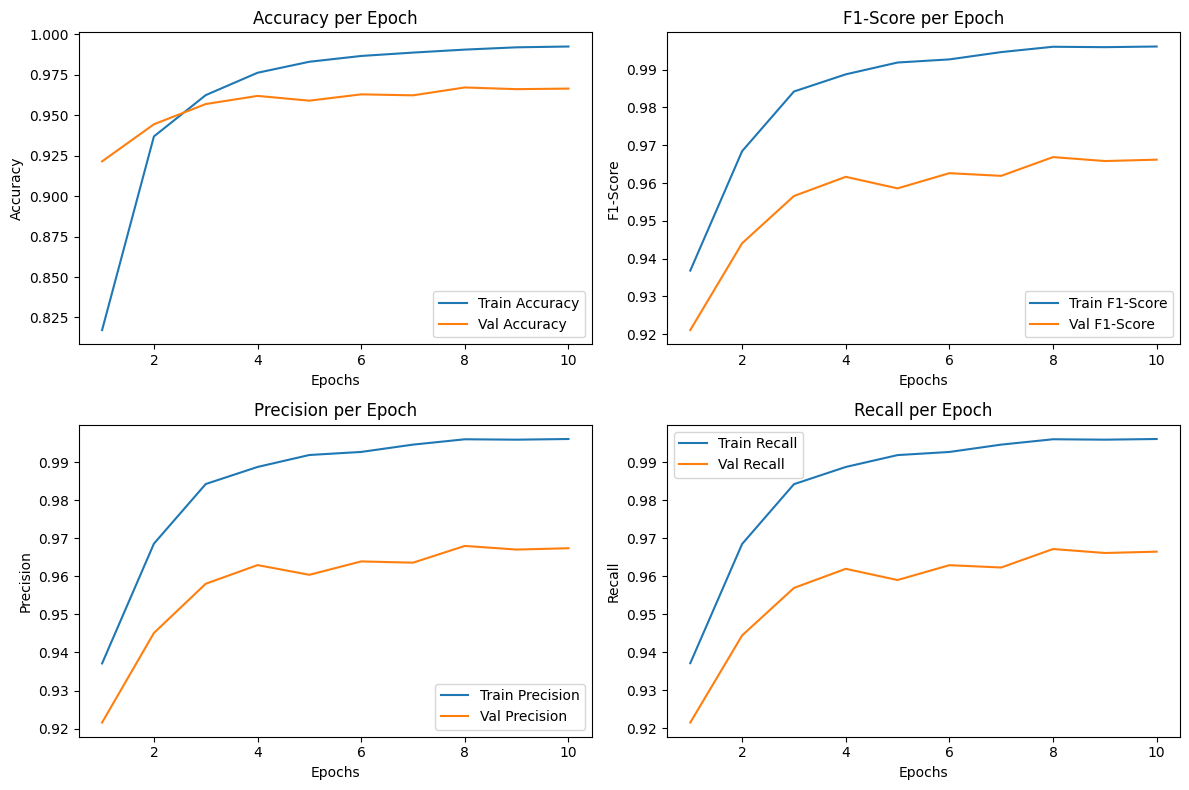

In [46]:
plot_metrics(metrics_callback)


In [47]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

 64/360 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


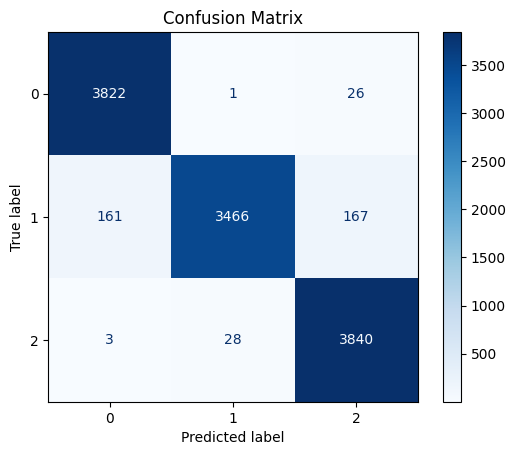

In [48]:
Conf_matrix(y_test, y_pred_classes)
